In [1]:
%load_ext autoreload

In [252]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mintpy.utils import readfile, utils as ut 
import h5py
from datetime import datetime

import datetime as dtt
from mintpy.objects import timeseries
from mintpy.utils import time_func, readfile, utils as ut
from mintpy.dem_error import read_exclude_date, read_geometry
from scipy import linalg
from minopy.simulation import simulate_noise
from minopy.lib.utils import est_corr_py
from scipy.linalg import lapack as lap
import minopy.find_short_baselines as fb
from scipy.spatial import Delaunay
from mintpy.utils import ptime
import datetime as dt
import matplotlib.dates as mdates
import random
out_dir = './out_figures'

In [253]:
def get_design_matrix4timeseries(date12_list, refDate=None):
    """Return design matrix of the input ifgramStack for timeseries estimation
    Parameters: date12_list - list of string in YYYYMMDD_YYYYMMDD format
                refDate     - str, date in YYYYMMDD format
                              set to None for the 1st date
                              set to 'no' to disable reference date
    Returns:    A - 2D array of float32 in size of (num_ifgram, num_date-1)
                B - 2D array of float32 in size of (num_ifgram, num_date-1)
    Examples:   obj = ifgramStack('./inputs/ifgramStack.h5')
                A, B = obj.get_design_matrix4timeseries(obj.get_date12_list(dropIfgram=True))
                A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate='20101022')[0]
                A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate=0)[0] #do not omit the 1st column
    """
    # Date info
    date12_list = list(date12_list)
    date1s = [i.split('_')[0] for i in date12_list]
    date2s = [i.split('_')[1] for i in date12_list]
    date_list = sorted(list(set(date1s + date2s)))
    num_ifgram = len(date12_list)
    num_date = len(date_list)

    # tbase in the unit of years
    date_format = ptime.get_date_str_format(date_list[0])
    dates = np.array([dt.datetime.strptime(i, date_format) for i in date_list])
    tbase = [i.days + i.seconds / (24 * 60 * 60) for i in (dates - dates[0])]
    tbase = np.array(tbase, dtype=np.float32) / 365.25

    # calculate design matrix
    # A for minimizing the residual of phase
    # B for minimizing the residual of phase velocity
    A = np.zeros((num_ifgram, num_date), np.float32)
    B = np.zeros((num_ifgram, num_date), np.float32)
    for i in range(num_ifgram):
        ind1, ind2 = [date_list.index(d) for d in date12_list[i].split('_')]
        A[i, ind1] = -1
        A[i, ind2] = 1
        # support date12_list with the first date NOT being the earlier date
        if ind1 < ind2:
            B[i, ind1:ind2] = tbase[ind1 + 1:ind2 + 1] - tbase[ind1:ind2]
        else:
            B[i, ind2:ind1] = tbase[ind2:ind1] - tbase[ind2 + 1:ind1 + 1]

    # Remove reference date as it can not be resolved
    if refDate != 'no':
        # default refDate
        if refDate is None:
            # for single   reference network, use the same reference date
            # for multiple reference network, use the first date
            if len(set(date1s)) == 1:
                refDate = date1s[0]
            else:
                refDate = date_list[0]

        # apply refDate
        if refDate:
            ind_r = date_list.index(refDate)
            A = np.hstack((A[:, 0:ind_r], A[:, (ind_r+1):]))
            B = B[:, :-1]

        return A, B


In [241]:
def delaunay_pairs(date_list, pbase, tbase, vel, wavelength, baseline_ratio=1, plot=False, annual=False):    
    min_baselines = min(pbase)
    max_baselines = max(pbase)
    
    days = [(datetime.strptime(date, '%Y%m%d') - datetime.strptime(date_list[0], '%Y%m%d')).days for date in date_list]

    temp2perp_scale = np.abs((max_baselines - min_baselines) / (np.nanmin(np.array(days)) - np.nanmax(np.array(days))))
    days = [tbase * temp2perp_scale for tbase in days]
    
    t_threshold = 180 * temp2perp_scale
    multplier = np.sqrt(baseline_ratio)
    days = [x / multplier for x in days]
    
    p_threshold = 400
    
    pairtr = []
    for i, date in enumerate(date_list):
        pairtr.append([days[i], pbase[i,0] * multplier])
    #import pdb; pdb.set_trace()
    pairtr = np.array(pairtr)
    tri = Delaunay(pairtr, incremental=False)

    qm = np.zeros([len(date_list), len(date_list)])
    
    for trp in pairtr[tri.simplices]:
        x1 = trp[0][0]
        x2 = trp[1][0]
        x3 = trp[2][0]
        b1 = trp[0][1]
        b2 = trp[1][1]
        b3 = trp[2][1]
        if np.abs(x1 - x2) <= t_threshold:
            qm[days.index(x1), days.index(x2)] = np.abs(b1 - b2)
            qm[days.index(x2), days.index(x1)] = np.abs(b1 - b2)
        if np.abs(x2 - x3) <= t_threshold:
            qm[days.index(x2), days.index(x3)] = np.abs(b2 - b3)
            qm[days.index(x3), days.index(x2)] = np.abs(b2 - b3)
        if np.abs(x1 - x3) <= t_threshold:
            qm[days.index(x1), days.index(x3)] = np.abs(b1 - b3)
            qm[days.index(x3), days.index(x1)] = np.abs(b1 - b3)

    qm[qm > p_threshold] = 0
    
    for i in range(len(date_list)):
        if len(np.nonzero(qm[i, :])[0]) <= 1:
            qm[i, :] = 0
            
    A = np.triu(qm)
    ind1, ind2 = np.where(A > 0)
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
        
    
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp = vel*(tbase[i]-tbase[j])
        ifg_values.append(disp*4*np.pi/wavelength)
    
    #fb.plot_baselines(ind1=ind1, ind2=ind2, dates=dates, baselines=baselines,
    #               out_dir=os.path.dirname(inps.out_file))
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
        
    ref_date = None
    return ifg_values, ifgdates, ref_date


def find_short_pbaseline_pair(baselines, date_list, ministack_size, last_index):

    second_index = np.arange(last_index - ministack_size + 1, last_index)
    diff_bselines = [np.abs(baselines[last_index - ministack_size - 2] - baselines[i]) for i in second_index]
    min_ind = np.min(diff_bselines)
    pair = (date_list[last_index - ministack_size - 2], date_list[second_index[diff_bselines.index(min_ind)]])
    
    return pair

def mini_stack_pairs(date_list, pbase,tbase, vel, wavelength, plot=False, annual=False):
    month = 6
    pairs=[]
    dates = [datetime.strptime(date_str, '%Y%m%d') for date_str in date_list]
    years = np.array([x.year for x in dates])
    u, indices_first = np.unique(years, return_index=True)
    f_ind = indices_first
    l_ind = np.zeros(indices_first.shape, dtype=np.int)
    l_ind[0:-1] = np.array(f_ind[1::]).astype(np.int)
    l_ind[-1] = len(dates)
    ref_inds = []
    for i in range(len(f_ind)):
        months = np.array([x.month for x in dates[f_ind[i]:l_ind[i]]])
        u, indices = np.unique(months, return_index=True)
        ind = np.where(u == month)[0]
        if len(ind) == 0:
            ind = int(len(u)//2)
        else:
            ind = ind[0]
        ref_ind = indices[ind] + f_ind[i]
        ref_inds.append(ref_ind)

        for k in range(f_ind[i], l_ind[i]):
            pairs.append((date_list[ref_ind], date_list[k]))
        ministack_size = l_ind[i] - f_ind[i]
        if i > 0:
            pairs.append(find_short_pbaseline_pair(pbase, date_list, ministack_size, l_ind[i]))
            
    for i in range(len(ref_inds)-1):
        pairs.append((date_list[ref_inds[i]], date_list[ref_inds[i+1]]))
        pairs.append((date_list[l_ind[i]-1], date_list[l_ind[i]]))
    
    ind1=[]
    ind2=[]
    
    
    
    for pair in pairs:
        ind1.append(date_list.index(pair[0]))
        ind2.append(date_list.index(pair[1]))
    
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
    
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp = vel*(tbase[i]-tbase[j])
        ifg_values.append(disp*4*np.pi/wavelength)
        
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
    
    ref_date = None
    return ifg_values, ifgdates, ref_date



def sequential_pairs(date_list, pbase,tbase, vel, wavelength, num_seq=2, plot=False, annual=False):
    pairs=[]
    for t in range(0, num_seq-1):
        for l in range(t + 1, num_seq):
            pairs.append((date_list[t], date_list[l]))
    for i in range(num_seq, len(date_list)):
        for t in range(1, num_seq + 1):
            pairs.append((date_list[i - t], date_list[i]))
            
    ind1=[]
    ind2=[]
    for pair in pairs:
        ind1.append(date_list.index(pair[0]))
        ind2.append(date_list.index(pair[1]))
        
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
        
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp = vel*(tbase[i]-tbase[j])
        ifg_values.append(disp*4*np.pi/wavelength)
        
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
        
    ref_date = None
    return ifg_values, ifgdates, ref_date



def single_reference_pairs(date_list, pbase,tbase, vel, wavelength, plot=False, annual=False):
    pairs=[]
    indx = int(len(date_list) // 2)
    reference_date = date_list[indx]
    for i in range(0, len(date_list)):
        if not indx == i:
            pairs.append((date_list[indx], date_list[i]))
    
    ind1=[]
    ind2=[]
    for pair in pairs:
        ind1.append(date_list.index(pair[0]))
        ind2.append(date_list.index(pair[1]))
        
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
        
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp = vel*(tbase[i]-tbase[j])
        ifg_values.append(disp*4*np.pi/wavelength)
        
        
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
        
   
    return ifg_values, ifgdates, reference_date


def find_one_year_interferograms(date_list):
    dates = np.array([dtt.datetime.strptime(date, '%Y%m%d') for date in date_list])

    #ifg_ind = []
    ind1 = []
    ind2 = []
    for i, date in enumerate(dates):
        range_1 = date + dtt.timedelta(days=365) - dtt.timedelta(days=5)
        range_2 = date + dtt.timedelta(days=365) + dtt.timedelta(days=5)
        index = np.where((dates >= range_1) * (dates <= range_2))[0]
        if len(index) >= 1:
            date_diff = list(dates[index] - (date + dtt.timedelta(days=365)))
            ind = date_diff.index(np.nanmin(date_diff))
            ind_date = index[ind]
            ind1.append(i)
            ind2.append(ind_date)
            #date2 = date_list[ind_date]
            #ifg_ind.append((date_list[i], date2))
            
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]

    return ifgdates, ind1, ind2


def plot_baselines(ind1, ind2, dates, pbase):
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    years_fmt = mdates.DateFormatter('%Y')
    
    ifgdates = ['{}_{}, {}, {}, {}\n'.format(dates[g], dates[h], str(pbase[g,0]),
                                             str(pbase[h,0]), str(pbase[g,0] - pbase[h,0]))
                for g, h in zip(ind1, ind2)]
    
    fig = plt.figure(figsize=(8, 4))
    
    for d in ifgdates:
        X = d.split(',')[0].split('_')
        x1 = datetime.strptime(X[0], '%Y%m%d')
        x2 = datetime.strptime(X[1], '%Y%m%d')

        Y = d.split('\n')[0].split(',')[1:3]
    
        y1 = float(Y[0])
        y2 = float(Y[1])
        plt.plot([x1, x2], [y1, y2], 'ko-', markersize=10)
        
    plt.xlabel('Time [years]')
    plt.ylabel('Perp Baseline [m]')
    
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.autoscale_view()
    plt.show()
    
    return



    

In [231]:
ts_file = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/srtm_2/timeseries.h5'
geom_file = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/srtm_2/geometryRadar.h5'

out_dir = './out_figures'

# Sentinel

ts_obj = timeseries(ts_file)

date_list = ts_obj.get_date_list()
indx1 = date_list.index('20180108')
indx2 = date_list.index('20191229')
date_list = date_list[indx1:indx2]

metadata = ts_obj.get_metadata()
sin_inc_angle, range_dist, pbase = read_geometry(ts_file, geom_file, box=None)

pbase = pbase[indx1:indx2]

wavelength = np.float(metadata['radarWavelength'])
seconds = metadata.get('CENTER_LINE_UTC', 0)
tbase = np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25
tbase_diff = np.diff(tbase).reshape(-1, 1)

open geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read mean bperp from timeseries file


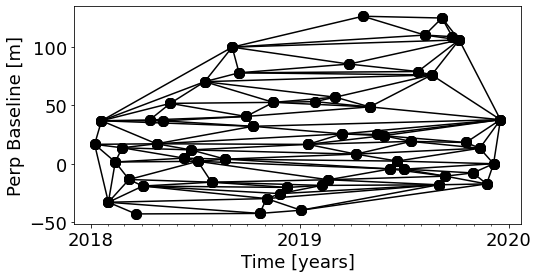

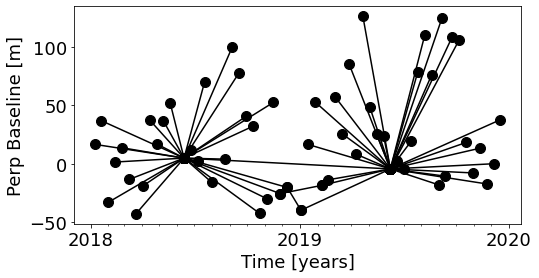

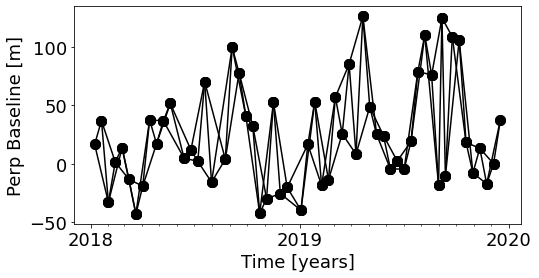

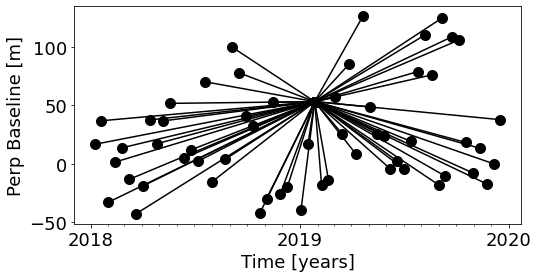

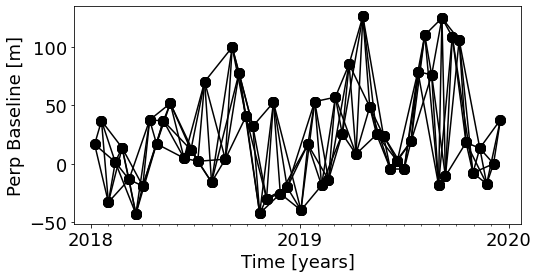

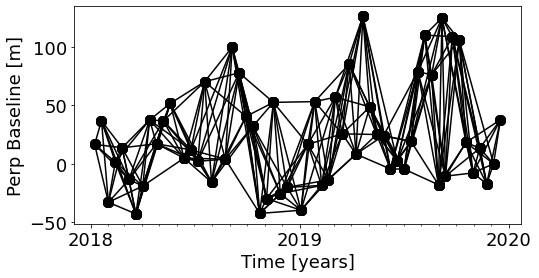

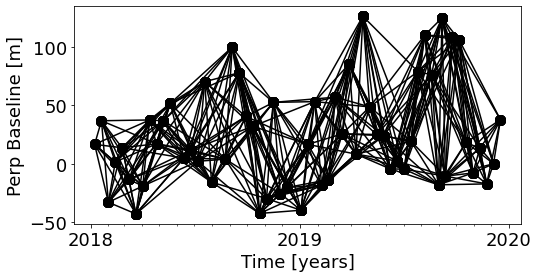

In [232]:
velo = 0   # cm/y

ifg_values_de, pairs_de, ref_date_de = delaunay_pairs(date_list, pbase, tbase, velo, wavelength, baseline_ratio=6, plot=True)
ifg_values_mi, pairs_mi, ref_date_mi = mini_stack_pairs(date_list, pbase, tbase, velo, wavelength, plot=True)
ifg_values_se, pairs_se, ref_date_se = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=2, plot=True)
ifg_values_si, pairs_si, ref_date_si = single_reference_pairs(date_list, pbase, tbase, velo, wavelength, plot=True)
ifg_values_se3, pairs_se3, ref_date_se3 = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=3, plot=True)
ifg_values_se5, pairs_se5, ref_date_se5 = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=5, plot=True)
ifg_values_se8, pairs_se8, ref_date_se8 = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=8, plot=True)



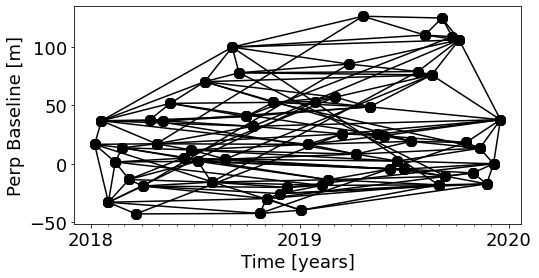

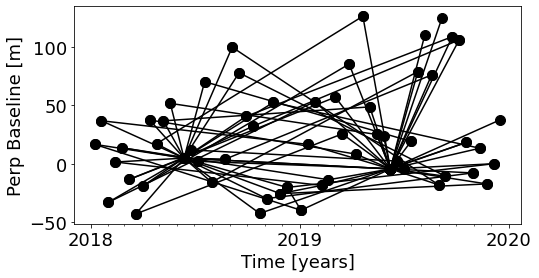

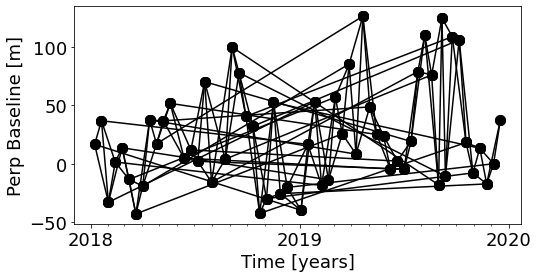

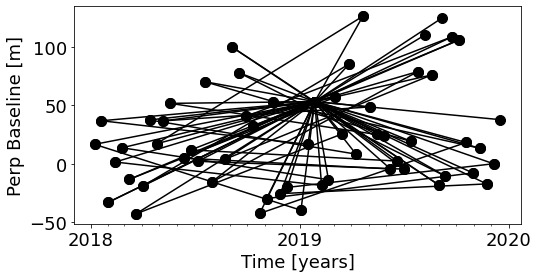

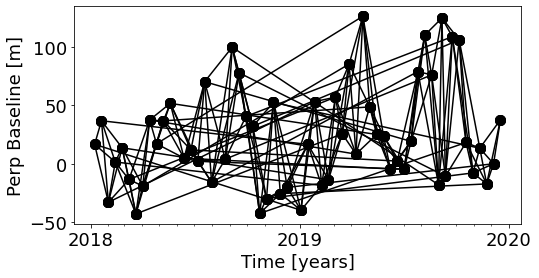

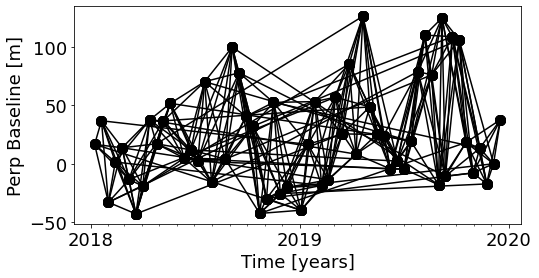

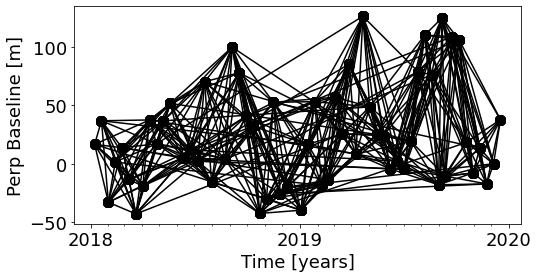

In [242]:

aifg_values_de, apairs_de, ref_date_de = delaunay_pairs(date_list, pbase, tbase, velo, wavelength, baseline_ratio=6, plot=True, annual=True)
aifg_values_mi, apairs_mi, ref_date_mi = mini_stack_pairs(date_list, pbase, tbase, velo, wavelength, plot=True, annual=True)
aifg_values_se, apairs_se, ref_date_se = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=2, plot=True, annual=True)
aifg_values_si, apairs_si, ref_date_si = single_reference_pairs(date_list, pbase, tbase, velo, wavelength, plot=True, annual=True)
aifg_values_se3, apairs_se3, ref_date_se3 = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=3, plot=True, annual=True)
aifg_values_se5, apairs_se5, ref_date_se5 = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=5, plot=True, annual=True)
aifg_values_se8, apairs_se8, ref_date_se8 = sequential_pairs(date_list, pbase, tbase, velo, wavelength, num_seq=8, plot=True, annual=True)


In [302]:
def invert_timeseries(date_list, pairs, ifg_values, ref_date, percentage=[5, 10], repeat=1, wavelength=0.056, noise_range=1, sign='random'):
    rcond=1e-5
    model = dict()
    model['polynomial'] = 1
    model['periodic']   = []
    model['step']       = []
    model['exp']        = dict()
    model['log']        = dict()
    num_run = len(percentage)
    phase2range = -1 * float(wavelength) / (4.*np.pi)
    num_date = len(date_list)
    num_param = 2
    
    ts_data = np.zeros((len(date_list), num_run))
    velocity = np.zeros((num_run,1))
    vel_std = np.zeros((num_run,1))
    
    for i in range(num_run):
        ts_data_1 = np.zeros((len(date_list), 1))
        est_ve_1 = 0 
        est_std_1 = 0
        d = int(percentage[i]*len(pairs)/100)
        
        xind = random.sample(range(0, len(pairs)), d)
        
        noise = np.empty((d,))
        if sign == 'random':
            if d == 1:
                noise[1] = 2*np.pi
            else:
                indm = d//2
                noise[0:indm] = 2*np.pi
                noise[indm::] = -2*np.pi
        elif sign == 'positive':
            noise[:] = 2*np.pi
        else:
            noise[:] = -2*np.pi
        
            
        ifg = np.zeros(np.array(ifg_values).shape)
        ifg[:] = np.array(ifg_values)[:] 
        ifg[xind] += noise

        A, B = get_design_matrix4timeseries(pairs, refDate=ref_date)
        X, e2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
        ts_diff = X.reshape(-1,1) * tbase_diff
        ts_data_1[1:] = np.cumsum(ts_diff, axis=0)
        ts_data_1[1:,] *= phase2range
    
        G, m, e2 = time_func.estimate_time_func(model=model,
                                                date_list=date_list,
                                                dis_ts=ts_data_1,
                                                seconds=seconds)
    
        Gplus = linalg.pinv(G)
        G_inv = linalg.inv(np.dot(G.T, G))
        m_var = e2.reshape(1, -1) / (num_date - num_param)
        m_std = np.sqrt(np.dot(np.diag(G_inv).reshape(-1, 1), m_var))
    
        est_ve_1 += m[1]
        est_std_1 += m_std[1]
    
    
        if repeat > 1:
        
            for q in range(1, repeat):
                ts_data_2 = np.zeros((len(date_list), 1))
                xind = random.sample(range(0, len(pairs)), d)
                noise = np.empty((d,))
                if sign == 'random':
                    if d == 1:
                        noise[1] = 2*np.pi
                    else:
                        indm = d//2
                        noise[0:indm] = 2*np.pi
                        noise[indm::] = -2*np.pi
                elif sign == 'positive':
                    noise[:] = 2*np.pi
                else:
                    noise[:] = -2*np.pi
                
                
                ifg = np.zeros(np.array(ifg_values).shape)
                ifg[:] = np.array(ifg_values)[:] 
                ifg[xind] += noise
        
                A, B = get_design_matrix4timeseries(pairs, refDate=ref_date)
                X, e2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
                ts_diff = X.reshape(-1,1) * tbase_diff
                ts_data_2[1:] = np.cumsum(ts_diff, axis=0) * phase2range
                ts_data_1 += ts_data_2
        
                G, m, e2 = time_func.estimate_time_func(model=model,
                                                        date_list=date_list,
                                                        dis_ts=ts_data_2,
                                                        seconds=seconds)
        
                Gplus = linalg.pinv(G)
                G_inv = linalg.inv(np.dot(G.T, G))
                m_var = e2.reshape(1, -1) / (num_date - num_param)
                m_std = np.sqrt(np.dot(np.diag(G_inv).reshape(-1, 1), m_var))
        
                est_ve_1 += m[1]
                est_std_1 += m_std[1]
        
        
            ts_data_1 /= repeat
            est_ve_1 /= repeat
            est_std_1 /= repeat
        velocity[i] = est_ve_1
        vel_std[i] = est_std_1
        ts_data[:, i] = ts_data_1.flatten()

    
    return ts_data, velocity, vel_std


def plot_unwrap_error(ts_data, velo, tbase, name=None, title=None, legend=None, out_dir=None, ylim = [-4,4]):
    #plt.rcParams["font.size"] = "18"
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months = mdates.MonthLocator()
    xx= [datetime.strptime(i, '%Y%m%d') for i in date_list]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

    axs.plot(xx, ts_data*100, '.', markersize=10)
    axs.plot(xx, velo*tbase*100, 'k')

    #plt.legend(legend, bbox_to_anchor=(1,1))
    axs.set_title(title, fontsize=18)
    axs.set_ylabel("Displacement [cm]")
    axs.set_xlabel("Time [Year]")
    axs.set_ylim(ylim)

    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    plt.savefig(out_dir +'/dot_{}.png'.format(name), bbox_inches='tight', dpi=300) 
    return

In [307]:
percentage = [5, 10]

legend = ['5%', '10%', 'No unwrap \nerror']
rep = 1

#### delaunay

ts_data_de, velocity_de, vel_std_de = invert_timeseries(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### single_reference

ts_data_si, velocity_si, vel_std_si = invert_timeseries(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### mini_stacks

ts_data_mi, velocity_mi, vel_std_mi = invert_timeseries(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 3 connections

ts_data_se3, velocity_se3, vel_std_se3 = invert_timeseries(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 5 connections

ts_data_se5, velocity_se5, vel_std_se5 = invert_timeseries(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 8 connections

ts_data_se8, velocity_se8, vel_std_se8 = invert_timeseries(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)


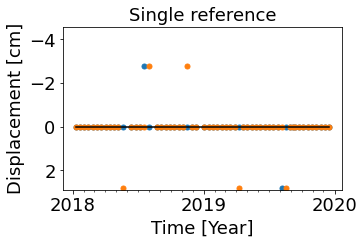

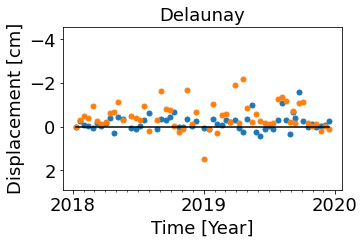

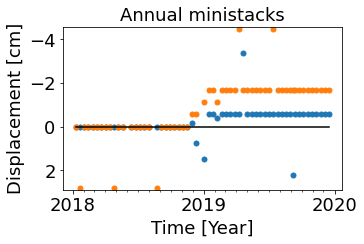

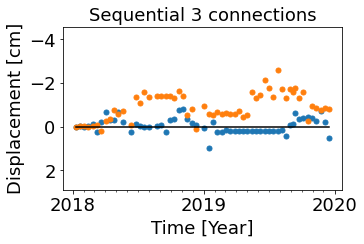

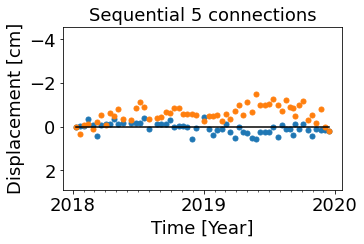

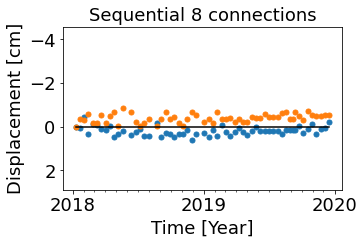

In [309]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1

plot_unwrap_error(ts_data_si, velo, tbase, name='1_ts_singlereference_unwrap_error', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_de, velo, tbase, name='1_ts_delaunay_unwrap_error', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_mi, velo, tbase, name='1_ts_ministacks_unwrap_error', 
                  title='Annual ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se3, velo, tbase, name='1_ts_sequential_3_unwrap_error', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se5, velo, tbase, name='1_ts_sequential_5_unwrap_error', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se8, velo, tbase, name='1_ts_sequential_8_unwrap_error', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

In [314]:
percentage = [5, 10]

legend = ['5%', '10%', 'No unwrap \nerror']
rep = 1

#### delaunay

ts_data_de, velocity_de, vel_std_de = invert_timeseries(date_list, apairs_de, aifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### single_reference

ts_data_si, velocity_si, vel_std_si = invert_timeseries(date_list, apairs_si, aifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### mini_stacks

ts_data_mi, velocity_mi, vel_std_mi = invert_timeseries(date_list, apairs_mi, aifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 3 connections

ts_data_se3, velocity_se3, vel_std_se3 = invert_timeseries(date_list, apairs_se3, aifg_values_se3, ref_date_se3, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 5 connections

ts_data_se5, velocity_se5, vel_std_se5 = invert_timeseries(date_list, apairs_se5, aifg_values_se5, ref_date_se5, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 8 connections

ts_data_se8, velocity_se8, vel_std_se8 = invert_timeseries(date_list, apairs_se8, aifg_values_se8, ref_date_se8, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)


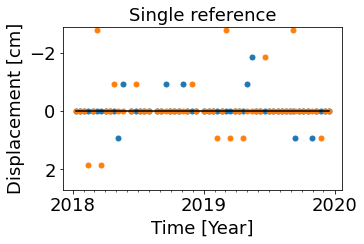

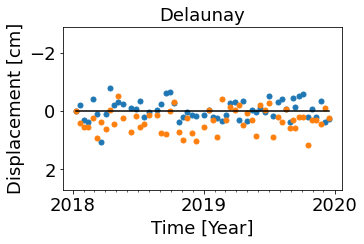

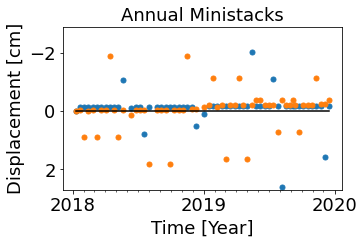

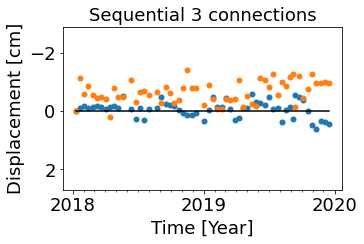

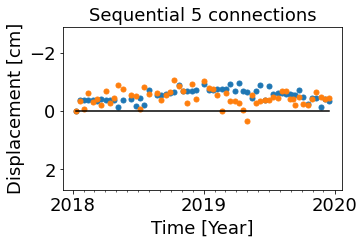

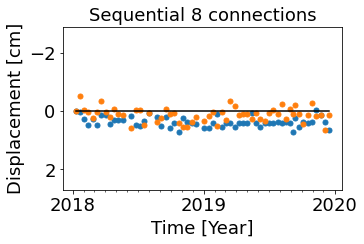

In [315]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1

plot_unwrap_error(ts_data_si, velo, tbase, name='1a_ts_singlereference_unwrap_error.png', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_de, velo, tbase, name='1a_ts_delaunay_unwrap_error.png', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_mi, velo, tbase, name='1a_ts_ministacks_unwrap_error.png', 
                  title='Annual Ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se3, velo, tbase, name='1a_ts_sequential_3_unwrap_error.png', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se5, velo, tbase, name='1a_ts_sequential_5_unwrap_error.png', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se8, velo, tbase, name='1a_ts_sequential_8_unwrap_error.png', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

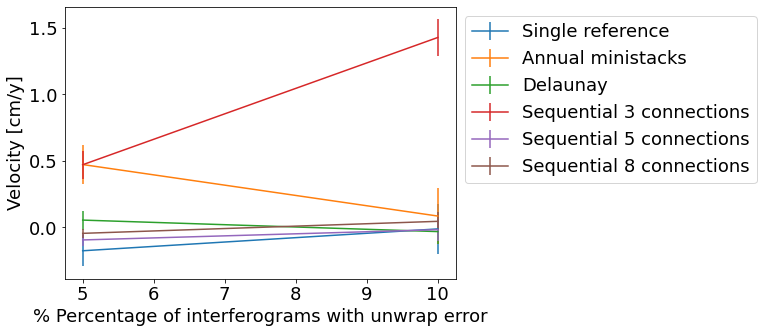

In [136]:
plt.rcParams["font.size"] = "18"

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
axs.errorbar(percentage, velocity_si*100, yerr=vel_std_si.flatten()*100)
axs.errorbar(percentage, velocity_mi*100, yerr=vel_std_mi.flatten()*100)
axs.errorbar(percentage, velocity_de*100, yerr=vel_std_de.flatten()*100)
#axs.errorbar(percentage, velocity_se*100, yerr=vel_std_se.flatten()*100)
axs.errorbar(percentage, velocity_se3*100, yerr=vel_std_se3.flatten()*100)
axs.errorbar(percentage, velocity_se5*100, yerr=vel_std_se5.flatten()*100)
axs.errorbar(percentage, velocity_se8*100, yerr=vel_std_se8.flatten()*100)

plt.legend(['Single reference', 'Annual ministacks', 'Delaunay',
           'Sequential 3 connections','Sequential 5 connections', 'Sequential 8 connections'], bbox_to_anchor=(1,1))

plt.xlabel('% Percentage of interferograms with unwrap error')
plt.ylabel('Velocity [cm/y]')

plt.savefig(out_dir +'/1_velocity_unwrap_error_2018-2019.png', bbox_inches='tight', dpi=300) 

#plt.savefig(out_dir +'/100_velocity_unwrap_error.png', bbox_inches='tight', dpi=300) 
#plt.savefig(out_dir +'/100_velocity_unwrap_error_2018-2019.png', bbox_inches='tight', dpi=300) 


In [161]:
## positive unwrap errors
percentage = [5, 10]

legend = ['5%', '10%', 'No unwrap \nerror']


#### delaunay

ts_data_de, velocity_de, vel_std_de = invert_timeseries(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='positive')

#### single_reference

ts_data_si, velocity_si, vel_std_si = invert_timeseries(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='positive')

#### mini_stacks

ts_data_mi, velocity_mi, vel_std_mi = invert_timeseries(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='positive')

#### sequential 3 connections

ts_data_se3, velocity_se3, vel_std_se3 = invert_timeseries(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='positive')

#### sequential 5 connections

ts_data_se5, velocity_se5, vel_std_se5 = invert_timeseries(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='positive')

#### sequential 8 connections

ts_data_se8, velocity_se8, vel_std_se8 = invert_timeseries(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='positive')


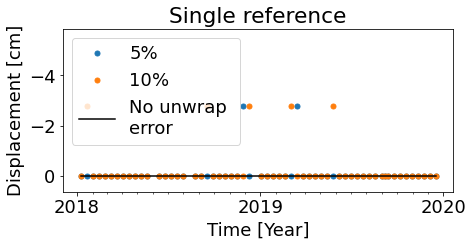

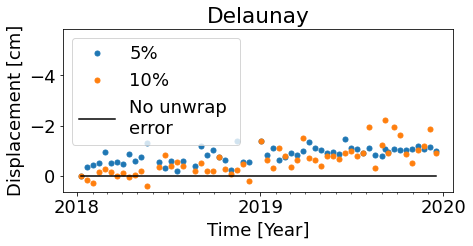

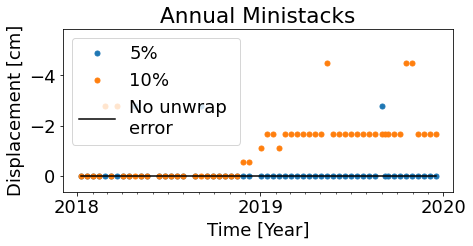

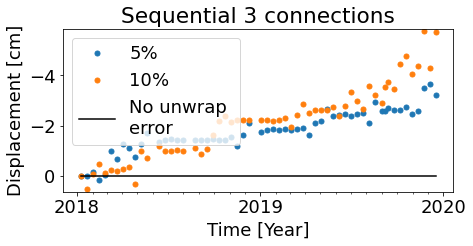

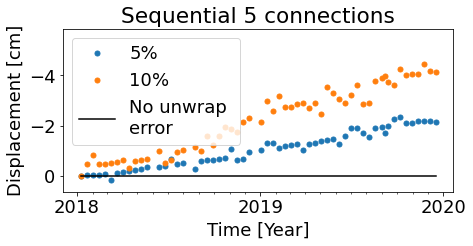

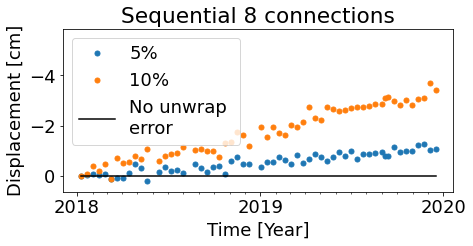

In [162]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1

plot_unwrap_error(ts_data_si, velo, tbase, name='1_pos_ts_singlereference_unwrap_error.png', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_de, velo, tbase, name='1_pos_ts_delaunay_unwrap_error.png', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_mi, velo, tbase, name='1_pos_ts_ministacks_unwrap_error.png', 
                  title='Annual Ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se3, velo, tbase, name='1_pos_ts_sequential_3_unwrap_error.png', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se5, velo, tbase, name='1_pos_ts_sequential_5_unwrap_error.png', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se8, velo, tbase, name='1_pos_ts_sequential_8_unwrap_error.png', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

In [163]:
## negative unwrap errors
percentage = [5, 10]

legend = ['5%', '10%', 'No unwrap \nerror']


#### delaunay

ts_data_de, velocity_de, vel_std_de = invert_timeseries(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='negative')

#### single_reference

ts_data_si, velocity_si, vel_std_si = invert_timeseries(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='negative')

#### mini_stacks

ts_data_mi, velocity_mi, vel_std_mi = invert_timeseries(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='negative')


#### sequential 3 connections

ts_data_se3, velocity_se3, vel_std_se3 = invert_timeseries(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='negative')

#### sequential 5 connections

ts_data_se5, velocity_se5, vel_std_se5 = invert_timeseries(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='negative')

#### sequential 8 connections

ts_data_se8, velocity_se8, vel_std_se8 = invert_timeseries(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='negative')


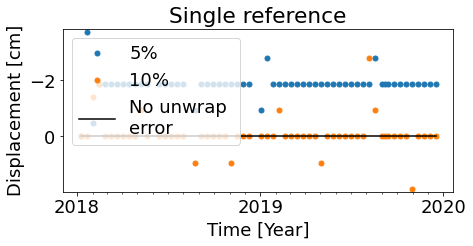

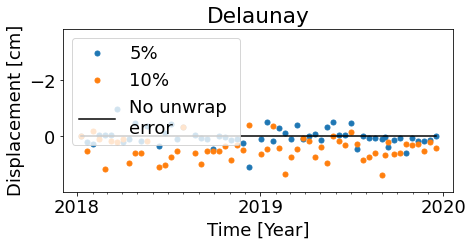

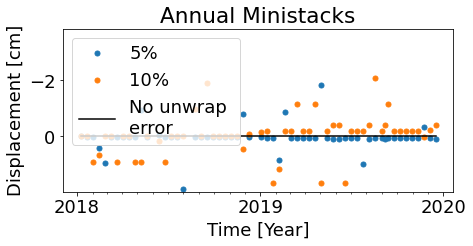

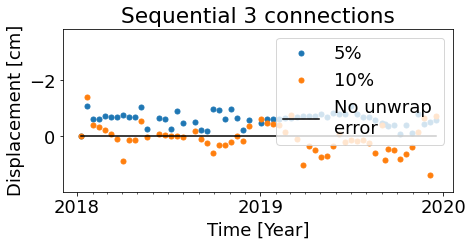

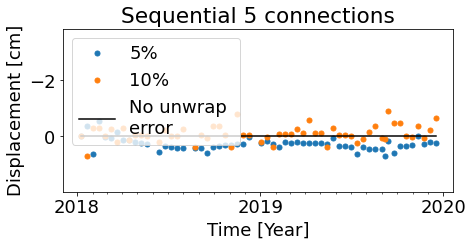

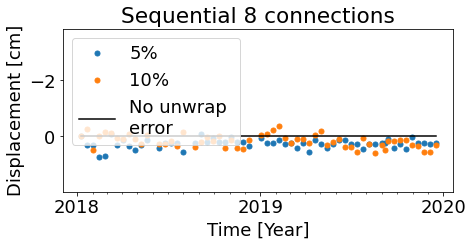

In [251]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1

plot_unwrap_error(ts_data_si, velo, tbase, name='1_neg_ts_singlereference_unwrap_error.png', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_de, velo, tbase, name='1_neg_ts_delaunay_unwrap_error.png', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_mi, velo, tbase, name='1_neg_ts_ministacks_unwrap_error.png', 
                  title='Annual Ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se3, velo, tbase, name='1_neg_ts_sequential_3_unwrap_error.png', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se5, velo, tbase, name='1_neg_ts_sequential_5_unwrap_error.png', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se8, velo, tbase, name='1_neg_ts_sequential_8_unwrap_error.png', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

In [182]:
tt = [pair.split('_')[1] for pair in pairs]
tt1 = np.array([datetime.strptime(im, '%Y%m%d').month for im in tt])
tt2 = np.sort(np.concatenate((np.where(tt1==11)[0], np.where(tt1==12)[0], np.where(tt1==1)[0])))
tt2

array([ 0,  1, 23, 24, 25, 26, 27, 28, 29, 54, 55, 56, 57, 60])

In [342]:
def invert_timeseries_seasonal(date_list, pairs, ifg_values, ref_date, percentage=[5, 10], repeat=1, wavelength=0.056, noise_range=1, sign='random'):
    rcond=1e-5
    model = dict()
    model['polynomial'] = 1
    model['periodic']   = []
    model['step']       = []
    model['exp']        = dict()
    model['log']        = dict()
    num_run = len(percentage)
    phase2range = -1 * float(wavelength) / (4.*np.pi)
    num_date = len(date_list)
    num_param = 2
    
    tt = [pair.split('_')[1] for pair in pairs]
    tt1 = np.array([datetime.strptime(im, '%Y%m%d').month for im in tt])
    tt2 = list(np.sort(np.concatenate((np.where(tt1==10)[0], np.where(tt1==11)[0], np.where(tt1==12)[0]))))
    
    ts_data = np.zeros((len(date_list), num_run))
    velocity = np.zeros((num_run,1))
    vel_std = np.zeros((num_run,1))
    
    
    for i in range(num_run):
        ts_data_1 = np.zeros((len(date_list), 1))
        est_ve_1 = 0 
        est_std_1 = 0
        d = len(tt2) #int(percentage[i]*len(pairs)/100)
        
        xind = random.sample(tt2, d)
        
        noise = np.empty((d,))
        if sign == 'random':
            if d == 1:
                noise[1] = 2*np.pi
            else:
                indm = d//2
                noise[0:indm] = 2*np.pi
                noise[indm::] = -2*np.pi
        elif sign == 'positive':
            noise[:] = 2*np.pi
        else:
            noise[:] = -2*np.pi
        
            
        ifg = np.zeros(np.array(ifg_values).shape)
        ifg[:] = np.array(ifg_values)[:] 
        ifg[xind] += noise

        A, B = get_design_matrix4timeseries(pairs, refDate=ref_date)
        X, e2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
        ts_diff = X.reshape(-1,1) * tbase_diff
        ts_data_1[1:] = np.cumsum(ts_diff, axis=0)
        ts_data_1[1:,] *= phase2range
    
        G, m, e2 = time_func.estimate_time_func(model=model,
                                                date_list=date_list,
                                                dis_ts=ts_data_1,
                                                seconds=seconds)
    
        Gplus = linalg.pinv(G)
        G_inv = linalg.inv(np.dot(G.T, G))
        m_var = e2.reshape(1, -1) / (num_date - num_param)
        m_std = np.sqrt(np.dot(np.diag(G_inv).reshape(-1, 1), m_var))
    
        est_ve_1 += m[1]
        est_std_1 += m_std[1]
    
    
        if repeat > 1:
        
            for q in range(1, repeat):
                ts_data_2 = np.zeros((len(date_list), 1))
                xind = random.sample(range(0, len(pairs)), d)
                noise = np.empty((d,))
                if sign == 'random':
                    if d == 1:
                        noise[1] = 2*np.pi
                    else:
                        indm = d//2
                        noise[0:indm] = 2*np.pi
                        noise[indm::] = -2*np.pi
                elif sign == 'positive':
                    noise[:] = 2*np.pi
                else:
                    noise[:] = -2*np.pi
                
                
                ifg = np.zeros(np.array(ifg_values).shape)
                ifg[:] = np.array(ifg_values)[:] 
                ifg[xind] += noise
        
                A, B = get_design_matrix4timeseries(pairs, refDate=ref_date)
                X, e2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
                ts_diff = X.reshape(-1,1) * tbase_diff
                ts_data_2[1:] = np.cumsum(ts_diff, axis=0) * phase2range
                ts_data_1 += ts_data_2
        
                G, m, e2 = time_func.estimate_time_func(model=model,
                                                        date_list=date_list,
                                                        dis_ts=ts_data_2,
                                                        seconds=seconds)
        
                Gplus = linalg.pinv(G)
                G_inv = linalg.inv(np.dot(G.T, G))
                m_var = e2.reshape(1, -1) / (num_date - num_param)
                m_std = np.sqrt(np.dot(np.diag(G_inv).reshape(-1, 1), m_var))
        
                est_ve_1 += m[1]
                est_std_1 += m_std[1]
        
        
            ts_data_1 /= repeat
            est_ve_1 /= repeat
            est_std_1 /= repeat
        velocity[i] = est_ve_1
        vel_std[i] = est_std_1
        ts_data[:, i] = ts_data_1.flatten()

    
    return ts_data, velocity, vel_std


def plot_unwrap_error_seas(ts_data, ts_data_s, velo, tbase, name=None, title=None, legend=None, out_dir=None, ylim = [-4,4]):
    #plt.rcParams["font.size"] = "18"
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months = mdates.MonthLocator()
    xx= [datetime.strptime(i, '%Y%m%d') for i in date_list]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

    axs.plot(xx, ts_data*100, '.', markersize=10)
    axs.plot(xx, ts_data_s*100+4, '.', markersize=10)

    axs.plot(xx, velo*tbase*100, 'k')
    
    axs.plot(xx, velo*tbase*100+4, 'k')

    plt.legend(legend, bbox_to_anchor=(1,1))
    axs.set_title(title, fontsize=18)
    axs.set_ylabel("Displacement [cm]")
    axs.set_xlabel("Time [Year]")
    #axs.set_ylim([ylim[0], ylim[1]+3])

    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    plt.savefig(out_dir +'/dot_{}'.format(name), bbox_inches='tight', dpi=300) 
    return

In [337]:
percentage = [5, 10]

legend = ['5%', '10%', 'No unwrap \nerror']
rep = 1

#### delaunay

ts_data_de, velocity_de, vel_std_de = invert_timeseries(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### single_reference

ts_data_si, velocity_si, vel_std_si = invert_timeseries(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### mini_stacks

ts_data_mi, velocity_mi, vel_std_mi = invert_timeseries(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 3 connections

ts_data_se3, velocity_se3, vel_std_se3 = invert_timeseries(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 5 connections

ts_data_se5, velocity_se5, vel_std_se5 = invert_timeseries(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)

#### sequential 8 connections

ts_data_se8, velocity_se8, vel_std_se8 = invert_timeseries(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                        percentage=percentage, repeat=rep, wavelength=0.056, noise_range=1)


In [338]:
percentage = [5]

legend = ['Seasonal', 'No unwrap \nerror']


#### delaunay

sts_data_de, svelocity_de, svel_std_de = invert_timeseries_seasonal(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, noise_range=1)

#### single_reference

sts_data_si, svelocity_si, svel_std_si = invert_timeseries_seasonal(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, noise_range=1)

#### mini_stacks

sts_data_mi, svelocity_mi, svel_std_mi = invert_timeseries_seasonal(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, noise_range=1)

#### sequential 3 connections

sts_data_se3, svelocity_se3, svel_std_se3 = invert_timeseries_seasonal(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, noise_range=1)

#### sequential 5 connections

sts_data_se5, svelocity_se5, svel_std_se5 = invert_timeseries_seasonal(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, noise_range=1)

#### sequential 8 connections

sts_data_se8, svelocity_se8, svel_std_se8 = invert_timeseries_seasonal(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, noise_range=1)


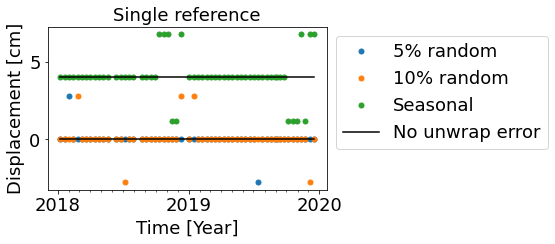

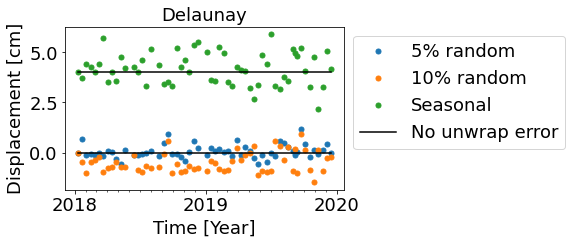

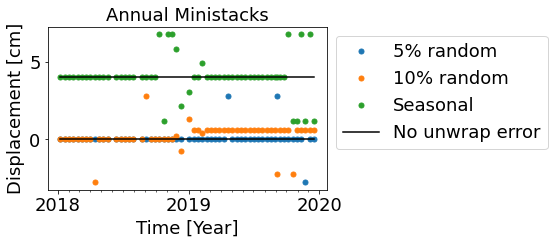

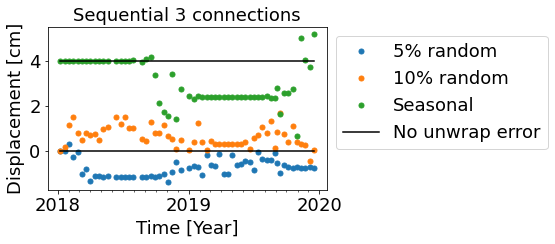

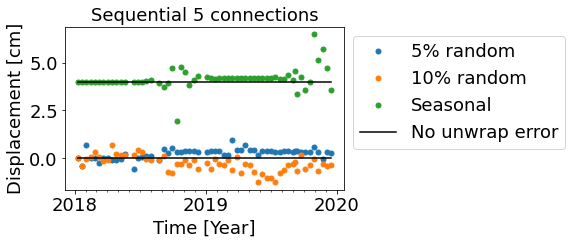

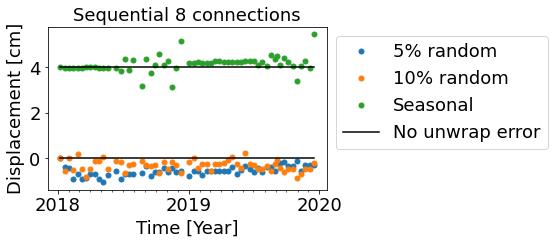

In [344]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1
legend = ['5% random', '10% random', 'Seasonal', 'No unwrap error']

plot_unwrap_error_seas(ts_data_si, sts_data_si, velo, tbase, name='2_singlereference_unwrap_error.png', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error_seas(ts_data_de, sts_data_de, velo, tbase, name='2_delaunay_unwrap_error.png', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error_seas(ts_data_mi, sts_data_mi, velo, tbase, name='2_ts_ministacks_unwrap_error.png', 
                  title='Annual Ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error_seas(ts_data_se3, sts_data_se3, velo, tbase, name='2_sequential_3_unwrap_error.png', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error_seas(ts_data_se5, sts_data_se5, velo, tbase, name='2_sequential_5_unwrap_error.png', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error_seas(ts_data_se8, sts_data_se8, velo, tbase, name='2_sequential_8_unwrap_error.png', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

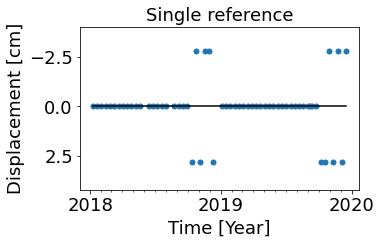

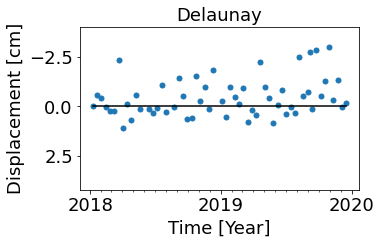

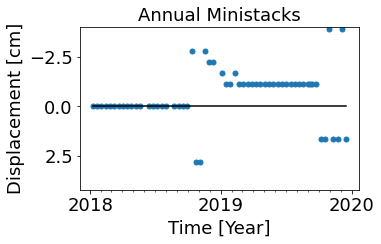

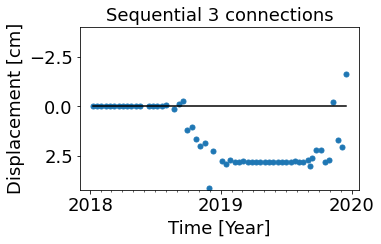

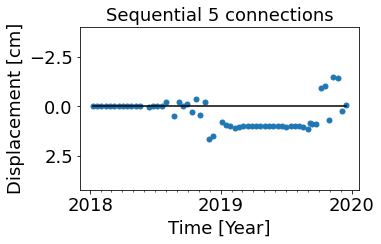

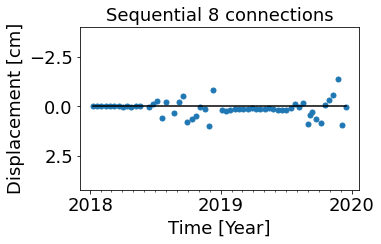

In [325]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1

plot_unwrap_error(ts_data_si, velo, tbase, name='seas_ts_singlereference_unwrap_error.png', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_de, velo, tbase, name='seas_ts_delaunay_unwrap_error.png', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_mi, velo, tbase, name='seas_ts_ministacks_unwrap_error.png', 
                  title='Annual Ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se3, velo, tbase, name='seas_ts_sequential_3_unwrap_error.png', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se5, velo, tbase, name='seas_ts_sequential_5_unwrap_error.png', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se8, velo, tbase, name='seas_ts_sequential_8_unwrap_error.png', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

In [207]:
## positive unwrap errors
percentage = [5]

legend = ['Seasonal', 'No unwrap \nerror']


#### delaunay

ts_data_de, velocity_de, vel_std_de = invert_timeseries_seasonal(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='positive')

#### single_reference

ts_data_si, velocity_si, vel_std_si = invert_timeseries_seasonal(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='positive')

#### mini_stacks

ts_data_mi, velocity_mi, vel_std_mi = invert_timeseries_seasonal(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='positive')

#### sequential 3 connections

ts_data_se3, velocity_se3, vel_std_se3 = invert_timeseries_seasonal(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='positive')

#### sequential 5 connections

ts_data_se5, velocity_se5, vel_std_se5 = invert_timeseries_seasonal(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='positive')

#### sequential 8 connections

ts_data_se8, velocity_se8, vel_std_se8 = invert_timeseries_seasonal(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='positive')


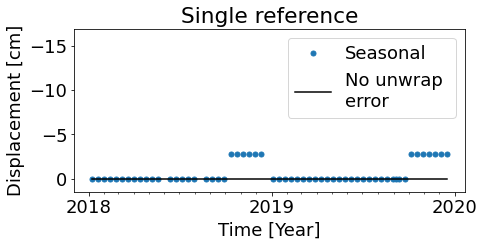

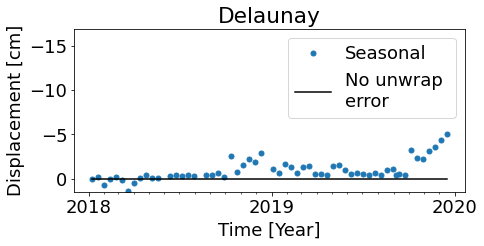

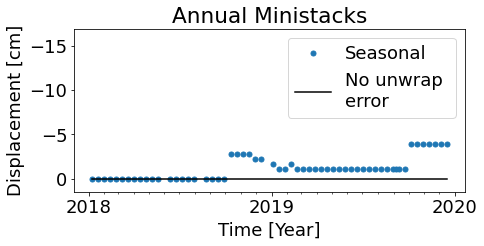

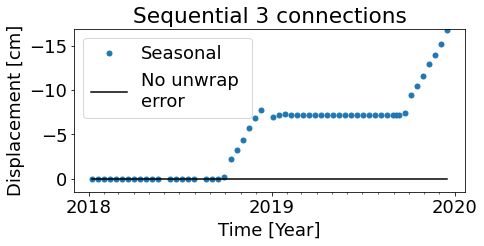

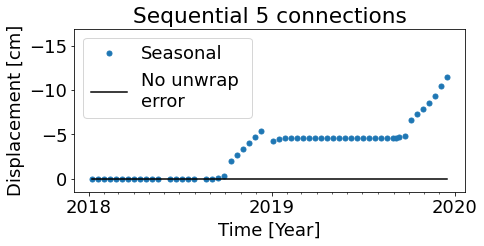

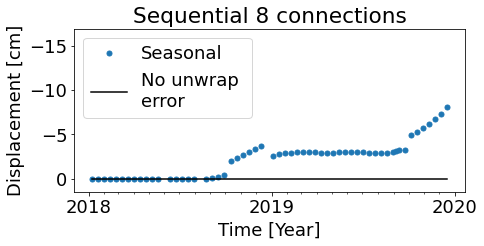

In [208]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1

plot_unwrap_error(ts_data_si, velo, tbase, name='seas_pos_ts_singlereference_unwrap_error.png', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_de, velo, tbase, name='seas_pos_ts_delaunay_unwrap_error.png', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_mi, velo, tbase, name='seas_pos_ts_ministacks_unwrap_error.png', 
                  title='Annual Ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se3, velo, tbase, name='seas_pos_ts_sequential_3_unwrap_error.png', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se5, velo, tbase, name='seas_pos_ts_sequential_5_unwrap_error.png', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se8, velo, tbase, name='seas_pos_ts_sequential_8_unwrap_error.png', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

In [209]:
## negative unwrap errors
percentage = [5]

legend = ['Seasonal', 'No unwrap \nerror']


#### delaunay

ts_data_de, velocity_de, vel_std_de = invert_timeseries_seasonal(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='negative')

#### single_reference

ts_data_si, velocity_si, vel_std_si = invert_timeseries_seasonal(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='negative')

#### mini_stacks

ts_data_mi, velocity_mi, vel_std_mi = invert_timeseries_seasonal(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                        percentage=percentage, repeat=1, wavelength=0.056, 
                                                        noise_range=1, sign='negative')

#### sequential 3 connections

ts_data_se3, velocity_se3, vel_std_se3 = invert_timeseries_seasonal(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='negative')

#### sequential 5 connections

ts_data_se5, velocity_se5, vel_std_se5 = invert_timeseries_seasonal(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='negative')

#### sequential 8 connections

ts_data_se8, velocity_se8, vel_std_se8 = invert_timeseries_seasonal(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                           percentage=percentage, repeat=1, wavelength=0.056, 
                                                           noise_range=1, sign='negative')


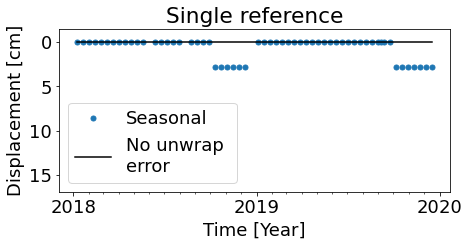

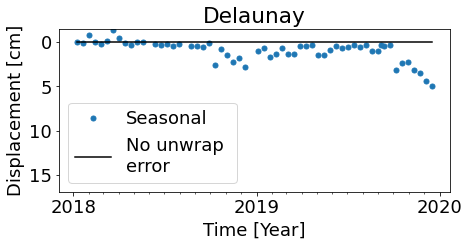

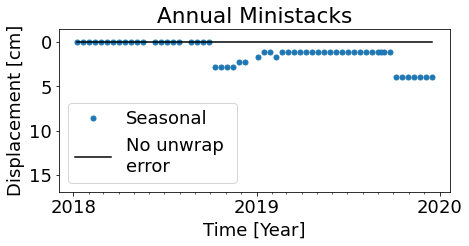

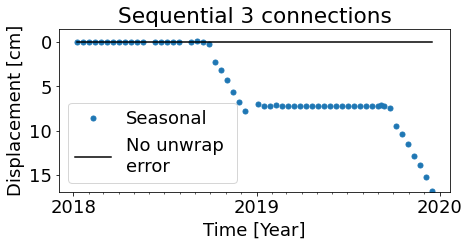

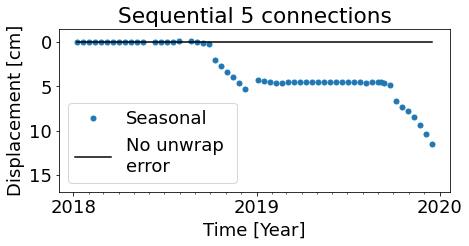

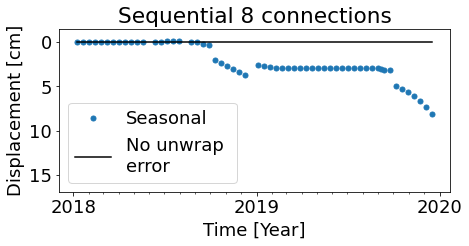

In [210]:
m1=np.max(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100+0.1
m2=np.min(np.concatenate((ts_data_si, ts_data_mi, ts_data_de, ts_data_se3, ts_data_se5, ts_data_se8)))*100-0.1

plot_unwrap_error(ts_data_si, velo, tbase, name='seas_neg_ts_singlereference_unwrap_error.png', 
                  title='Single reference', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_de, velo, tbase, name='seas_neg_ts_delaunay_unwrap_error.png', 
                  title='Delaunay', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_mi, velo, tbase, name='seas_neg_ts_ministacks_unwrap_error.png', 
                  title='Annual Ministacks', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se3, velo, tbase, name='seas_neg_ts_sequential_3_unwrap_error.png', 
                  title='Sequential 3 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se5, velo, tbase, name='seas_neg_ts_sequential_5_unwrap_error.png', 
                  title='Sequential 5 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])

plot_unwrap_error(ts_data_se8, velo, tbase, name='seas_neg_ts_sequential_8_unwrap_error.png', 
                  title='Sequential 8 connections', legend=legend, out_dir=out_dir, ylim = [m1, m2])